<a href="https://colab.research.google.com/github/zainab9271/AI-Dojo_Machine_learning_bootcamp/blob/main/Assignment_06_Computer_Vision_Applications_Zainab_Mahmood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 06: Computer Vision Applications

This Week's assignment is to train semantic segmentation models on the `Satellite buildings` images dataset.

Before starting copy this file and work on your own copy by following the below steps: <br>
`File > Save Copy in Drive`. Then add your name to the file (e.g., Assignment 06: Computer Vision Applications - Muntadher Alkaabi).


**Submission Deadline: Thursday, 2/24/2022 at 3:00 PM**

**Requirements:**

1. Import all necessary libraries for the semantic segmentation project.
2. Download the dataset (the link is provided below).
3. Create a function that convert the images path into dataframe(make sure that the images and their masks are matching). 
4. Make sure to convert the mask into one hot vector.
5. Split the dataset into train and test dateset (test dataset should be 10% of the total dataset).
6. Create data pipeline with data augmentation.
    1. Read images using tensorflow.
    2. Make sure the pixels values are scaled between (`0-1`).
    3. Resize the images to (224,224).
    4. Apply multiple image augmentation on the data (make sure that the image augmentation is reflected on its mask).
    5. Make sure the augmentation image pixels are scaled between (`0-1`). 
7. Plot the images.
8. Build Autoencoder model.

9. Build UNet model.<br>
**Note:** use sub-class to create the model.


10. Plot the model results.


**Note:** To get the best performance from the model, manually tune the hyperparameters of each model. 

Find relevant links below:<br>

[Assigment Colab File](https://colab.research.google.com/drive/1eoR4qjszwxieYTqPu2da8-kpOKtb0hod?usp=sharing)<br>
[Dataset](https://www.kaggle.com/hyyyrwang/buildings-dataset)

[Submission Form](https://docs.google.com/forms/d/e/1FAIpQLSfzW6FI2urJ-zlAV8sS9brv4cbpe6npmQg5KuD83nifeUgwHw/viewform?usp=pp_url)<br>
[How to use kaggle with colab](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)<br>


Good luck and feel free to ask any questions in the or on the Questions channel.

# 1- Import all necessary libraries for the semantic segmentation project

In [ ]:
# write your code below

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tqdm
from sklearn import model_selection

# 2- Download the dataset

In [ ]:
# download the required dataset from kaggle 
# write your code below

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d hyyyrwang/buildings-dataset

 98% 825M/842M [00:06<00:00, 157MB/s]
100% 842M/842M [00:06<00:00, 140MB/s]


In [ ]:
!unzip /content/buildings-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: src/T1886.png           
  inflating: src/T1887.png           
  inflating: src/T1888.png           
  inflating: src/T1889.png           
  inflating: src/T189.png            
  inflating: src/T1890.png           
  inflating: src/T1891.png           
  inflating: src/T1892.png           
  inflating: src/T1893.png           
  inflating: src/T1894.png           
  inflating: src/T1895.png           
  inflating: src/T1896.png           
  inflating: src/T1897.png           
  inflating: src/T1898.png           
  inflating: src/T1899.png           
  inflating: src/T19.png             
  inflating: src/T190.png            
  inflating: src/T1900.png           
  inflating: src/T1901.png           
  inflating: src/T1902.png           
  inflating: src/T1903.png           
  inflating: src/T1904.png           
  inflating: src/T1905.png           
  inflating: src/T1906.png           
  inflating: src/T1907.png           

# 3- Create a function that converts the images paths into a dataframe(make sure that the images and their masks are matching)

In [ ]:
# write your code below

def create_dataframe(masks_path, images_path):
    images_name = os.listdir(masks_path)
    masks_list = []
    images_list = []
    for index in tqdm.tqdm(range(len(images_name))):
        masks_list.append(masks_path + '/'+ images_name[index])
        images_list.append(images_path + '/'+ images_name[index])

    df = pd.DataFrame({'images': images_list, 'masks': masks_list})
    return df

dataframe = create_dataframe('/content/label', '/content/src')
dataframe

100%|██████████| 6030/6030 [00:00<00:00, 1001848.01it/s]


,images,masks
0,/content/src/T1829.png,/content/label/T1829.png
1,/content/src/T2728.png,/content/label/T2728.png
2,/content/src/T533.png,/content/label/T533.png
3,/content/src/W1442.png,/content/label/W1442.png
4,/content/src/W184.png,/content/label/W184.png
...,...,...
6025,/content/src/T2920.png,/content/label/T2920.png
6026,/content/src/T3252.png,/content/label/T3252.png
6027,/content/src/T3389.png,/content/label/T3389.png
6028,/content/src/T3744.png,/content/label/T3744.png


# 4- Convert the mask into one hot vector

In [ ]:
# write your code below

NUM_CLASSES = 2

# The masks will be converted to one hot vector when this function is called while creating data pipline.
def read_image(x,y):

    x = tf.io.read_file(x)
    x = tf.image.decode_png(x, channels=3)
    x = tf.image.convert_image_dtype(x, tf.float32)
    x = tf.image.resize(x , [224,224])
    x = tf.clip_by_value(x, 0, 1)

    y = tf.io.read_file(y)
    y = tf.image.decode_png(y, channels=1)
    y = tf.image.resize(y, [224,224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    y = tf.clip_by_value(y, 0, 1)
    y = tf.reshape(y, (224,224))
    y = tf.one_hot(y, depth=NUM_CLASSES)

    return x,y


# 5- Split the dataset into train and test dateset (test dataset should be 10% of the total dataset)

In [ ]:
# write your code below

train, test = model_selection.train_test_split(dataframe, test_size=0.1, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
print(train.shape)
print(test.shape)

(5427, 2)
(603, 2)


# 6- Create data pipeline with data augmentation

Notes:<br>
1. Read images using tensorflow.
2. Make sure the pixels values are scaled between (0-1).
3. Resize the images to (224,224).
4. Apply multiple image augmentation on the data(make sure that the image augmentation is reflected on its mask).
5. Make sure the augmentation image pixels are scaled between (0-1).

In [ ]:
# write your code below

def data_aug(x,y):
    seed = np.random.randint(low=0, high=100, size=1)

    x = tf.image.random_flip_left_right(x, seed= seed[0])
    x = tf.image.random_flip_up_down(x, seed= seed[0])
    x = tf.image.random_saturation(x, lower=0.5, upper=1.5)
    x = tf.image.random_brightness(x, max_delta=32.0 / 255.0)
    x = tf.clip_by_value(x, 0.0, 1.0)

    y = tf.argmax(y, axis=-1)
    y = tf.reshape(y, shape=(224,224,1))
    y = tf.image.random_flip_left_right(y, seed= seed[0])
    y = tf.image.random_flip_up_down(y, seed= seed[0])
    y = tf.reshape(y, shape=(224,224))
    y = tf.one_hot(y, depth=NUM_CLASSES)

    return x, y

def create_dataset(x, y, training=False):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.shuffle(1028,reshuffle_each_iteration=True)
    data = data.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        data = data.map(data_aug, num_parallel_calls=tf.data.AUTOTUNE)
    
    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

train_dataset = create_dataset(train.images, train.masks, training=True)
test_dataset = create_dataset(test.images, test.masks, training=False)



# 7- Plot the images

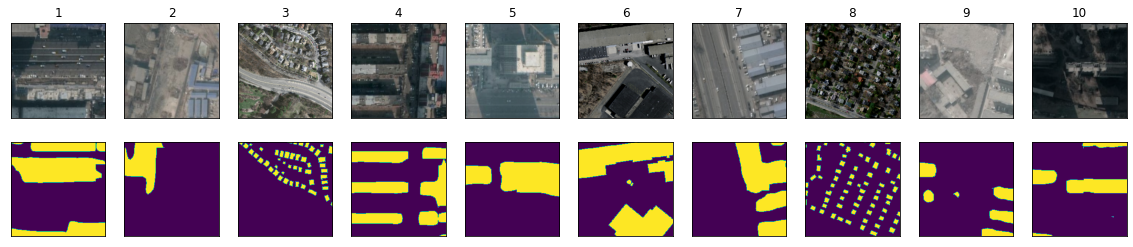

In [ ]:
# write your code below

n = 10
plt.figure(figsize=(20, 4))

for x,y in train_dataset.take(1):
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.title(f"{i+1}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x[i])
    
        plt.subplot(2, n, n+i + 1)
        plt.xticks([])
        plt.yticks([])    
        plt.imshow(tf.argmax(y[i],-1).numpy().reshape(224,224))
  

# 8- Build Autoencoder model

## Convolution Block

In [ ]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filter):
        super(ConvBlock, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters= filter, kernel_size=(3,3), padding='same', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters= filter, kernel_size=(3,3), padding='same', use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.leaky_relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = tf.nn.leaky_relu(x)

        return x


## Encoder Block

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(EncoderBlock, self).__init__()

        self.convBlock = ConvBlock(filter=filters)
        self.maxPool = tf.keras.layers.MaxPool2D()


    def call(self, x):
        x = self.convBlock(x)
        p = self.maxPool(x)

        return p, x


## Decoder Block

In [ ]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters, forUnet = False):
        super(DecoderBlock, self).__init__()

        self.forUnet = forUnet

        self.convT = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=(2,2), strides=(2,2), padding='same')
        self.convBlock = ConvBlock(filter= filters)

    def call(self, input, skip_features = None):
        x = self.convT(input)

        if self.forUnet:
            x = tf.keras.layers.concatenate([x, skip_features])

        x = self.convBlock(x)

        return x



## Autoencoder Model

In [ ]:
tf.keras.backend.clear_session()
class Autoencoder_Model(tf.keras.Model):
    def __init__(self, n_classes=NUM_CLASSES):
        super(Autoencoder_Model, self).__init__()

        self.encoder_block1 = EncoderBlock(filters=8)
        self.encoder_block2 = EncoderBlock(filters=16)
        self.encoder_block3 = EncoderBlock(filters=32)
        self.encoder_block4 = EncoderBlock(filters=64)
        self.encoder_block5 = EncoderBlock(filters=128)

        self.decoder_block1 = DecoderBlock(filters=128)
        self.decoder_block2 = DecoderBlock(filters=64)
        self.decoder_block3 = DecoderBlock(filters=32)
        self.decoder_block4 = DecoderBlock(filters=16)
        self.decoder_block5 = DecoderBlock(filters=8)

        self.out=tf.keras.layers.Conv2DTranspose(filters=n_classes, kernel_size=(1,1))

    def call(self, x):
        x = self.encoder_block1(x)
        x = self.encoder_block2(x[0])
        x = self.encoder_block3(x[0])
        x = self.encoder_block4(x[0])
        x = self.encoder_block5(x[0])
        
        x = self.decoder_block1(x[0])
        x = self.decoder_block2(x)
        x = self.decoder_block3(x)
        x = self.decoder_block4(x)
        x = self.decoder_block5(x)
        
        x = self.out(x)
        x = tf.nn.softmax(x)

        return x

    def build_model(self, shape=(224,224,3)):
        x = tf.keras.layers.Input(shape)
        return(tf.keras.Model(inputs=[x], outputs=[self.call(x)]))

model_autoEnc = Autoencoder_Model()
model_autoEnc.build_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 encoder_block (EncoderBlock  ((None, 112, 112, 8),    856       
 )                            (None, 224, 224, 8))               
                                                                 
 encoder_block_1 (EncoderBlo  ((None, 56, 56, 16),     3584      
 ck)                          (None, 112, 112, 16))              
                                                                 
 encoder_block_2 (EncoderBlo  ((None, 28, 28, 32),     14080     
 ck)                          (None, 56, 56, 32))                
                                                                 
 encoder_block_3 (EncoderBlo  ((None, 14, 14, 64),     55808     
 ck)                          (None, 28, 28, 64))            

### Model Training

In [ ]:
model_autoEnc.compile(optimizer=tf.optimizers.Adam(), loss= tf.losses.CategoricalCrossentropy(), metrics=['acc'])
model_autoEnc.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
170/170 [==============================] - 46s 256ms/step - loss: 0.4949 - acc: 0.7934 - val_loss: 0.7506 - val_acc: 0.7941
Epoch 2/10
170/170 [==============================] - 41s 242ms/step - loss: 0.3708 - acc: 0.8454 - val_loss: 0.6158 - val_acc: 0.8084
Epoch 3/10
170/170 [==============================] - 43s 252ms/step - loss: 0.3479 - acc: 0.8546 - val_loss: 0.4127 - val_acc: 0.8421
Epoch 4/10
170/170 [==============================] - 42s 245ms/step - loss: 0.3293 - acc: 0.8625 - val_loss: 0.4135 - val_acc: 0.8451
Epoch 5/10
170/170 [==============================] - 42s 244ms/step - loss: 0.3197 - acc: 0.8666 - val_loss: 0.3525 - val_acc: 0.8580
Epoch 6/10
170/170 [==============================] - 42s 247ms/step - loss: 0.3136 - acc: 0.8689 - val_loss: 0.3705 - val_acc: 0.8515
Epoch 7/10
170/170 [==============================] - 42s 246ms/step - loss: 0.3007 - acc: 0.8742 - val_loss: 0.3948 - val_acc: 0.8532
Epoch 8/10
170/170 [==============================] - 4

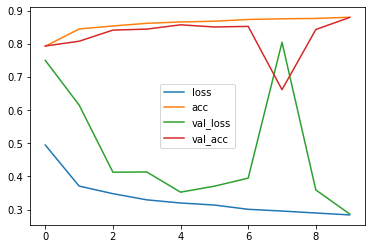

In [ ]:
pd.DataFrame(model_autoEnc.history.history).plot()

### Result Plot

# 9- Build UNet model

Note: use sub-class to create the model.

In [ ]:
# write your code below
tf.keras.backend.clear_session()
class Unet_Model(tf.keras.Model):
    def __init__(self, n_classes=NUM_CLASSES):
        super(Unet_Model, self).__init__()

        self.encoder_block1 = EncoderBlock(filters=8)
        self.encoder_block2 = EncoderBlock(filters=16)
        self.encoder_block3 = EncoderBlock(filters=32)
        self.encoder_block4 = EncoderBlock(filters=64)
        self.encoder_block5 = EncoderBlock(filters=128)

        self.conv_block = ConvBlock(filter= 256)

        self.decoder_block1 = DecoderBlock(filters=128, forUnet=True)
        self.decoder_block2 = DecoderBlock(filters=64, forUnet=True)
        self.decoder_block3 = DecoderBlock(filters=32, forUnet=True)
        self.decoder_block4 = DecoderBlock(filters=16, forUnet=True)
        self.decoder_block5 = DecoderBlock(filters=8, forUnet=True)

        self.out=tf.keras.layers.Conv2DTranspose(filters=n_classes, kernel_size=(1,1))

    def call(self, x):
        x, skipF1 = self.encoder_block1(x)
        x, skipF2 = self.encoder_block2(x)
        x, skipF3 = self.encoder_block3(x)
        x, skipF4 = self.encoder_block4(x)
        x, skipF5 = self.encoder_block5(x)

        x = self.conv_block(x)

        x = self.decoder_block1(x, skipF5)
        x = self.decoder_block2(x, skipF4)
        x = self.decoder_block3(x, skipF3)
        x = self.decoder_block4(x, skipF2)
        x = self.decoder_block5(x, skipF1)

        x = self.out(x)
        x = tf.nn.softmax(x)

        return x

    def build_model(self, shape=(224,224,3)):
        x = tf.keras.layers.Input(shape)
        return tf.keras.Model(inputs=[x], outputs=[self.call(x)])

model_unet = Unet_Model()
model_unet.build_model().summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_block (EncoderBlock)   ((None, 112, 112, 8  856         ['input_1[0][0]']                
                                ),                                                                
                                 (None, 224, 224, 8                                               
                                ))                                                                
                                                                                              

## Model Training

In [ ]:
model_unet.compile(optimizer=tf.optimizers.Adam(), loss= tf.losses.CategoricalCrossentropy(), metrics=['acc'])
model_unet.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
170/170 [==============================] - 47s 257ms/step - loss: 0.4222 - acc: 0.8344 - val_loss: 0.5919 - val_acc: 0.7426
Epoch 2/10
170/170 [==============================] - 44s 256ms/step - loss: 0.3410 - acc: 0.8601 - val_loss: 0.5069 - val_acc: 0.7754
Epoch 3/10
170/170 [==============================] - 42s 248ms/step - loss: 0.3229 - acc: 0.8666 - val_loss: 0.3366 - val_acc: 0.8614
Epoch 4/10
170/170 [==============================] - 42s 249ms/step - loss: 0.3079 - acc: 0.8731 - val_loss: 0.4131 - val_acc: 0.8493
Epoch 5/10
170/170 [==============================] - 42s 247ms/step - loss: 0.2951 - acc: 0.8772 - val_loss: 0.3564 - val_acc: 0.8537
Epoch 6/10
170/170 [==============================] - 42s 249ms/step - loss: 0.2860 - acc: 0.8815 - val_loss: 0.2991 - val_acc: 0.8755
Epoch 7/10
170/170 [==============================] - 42s 249ms/step - loss: 0.2732 - acc: 0.8863 - val_loss: 0.2757 - val_acc: 0.8887
Epoch 8/10
170/170 [==============================] - 4

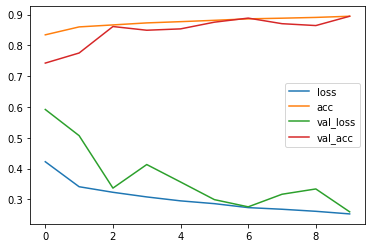

In [ ]:
pd.DataFrame(model_unet.history.history).plot()

# 10- Plot the model results

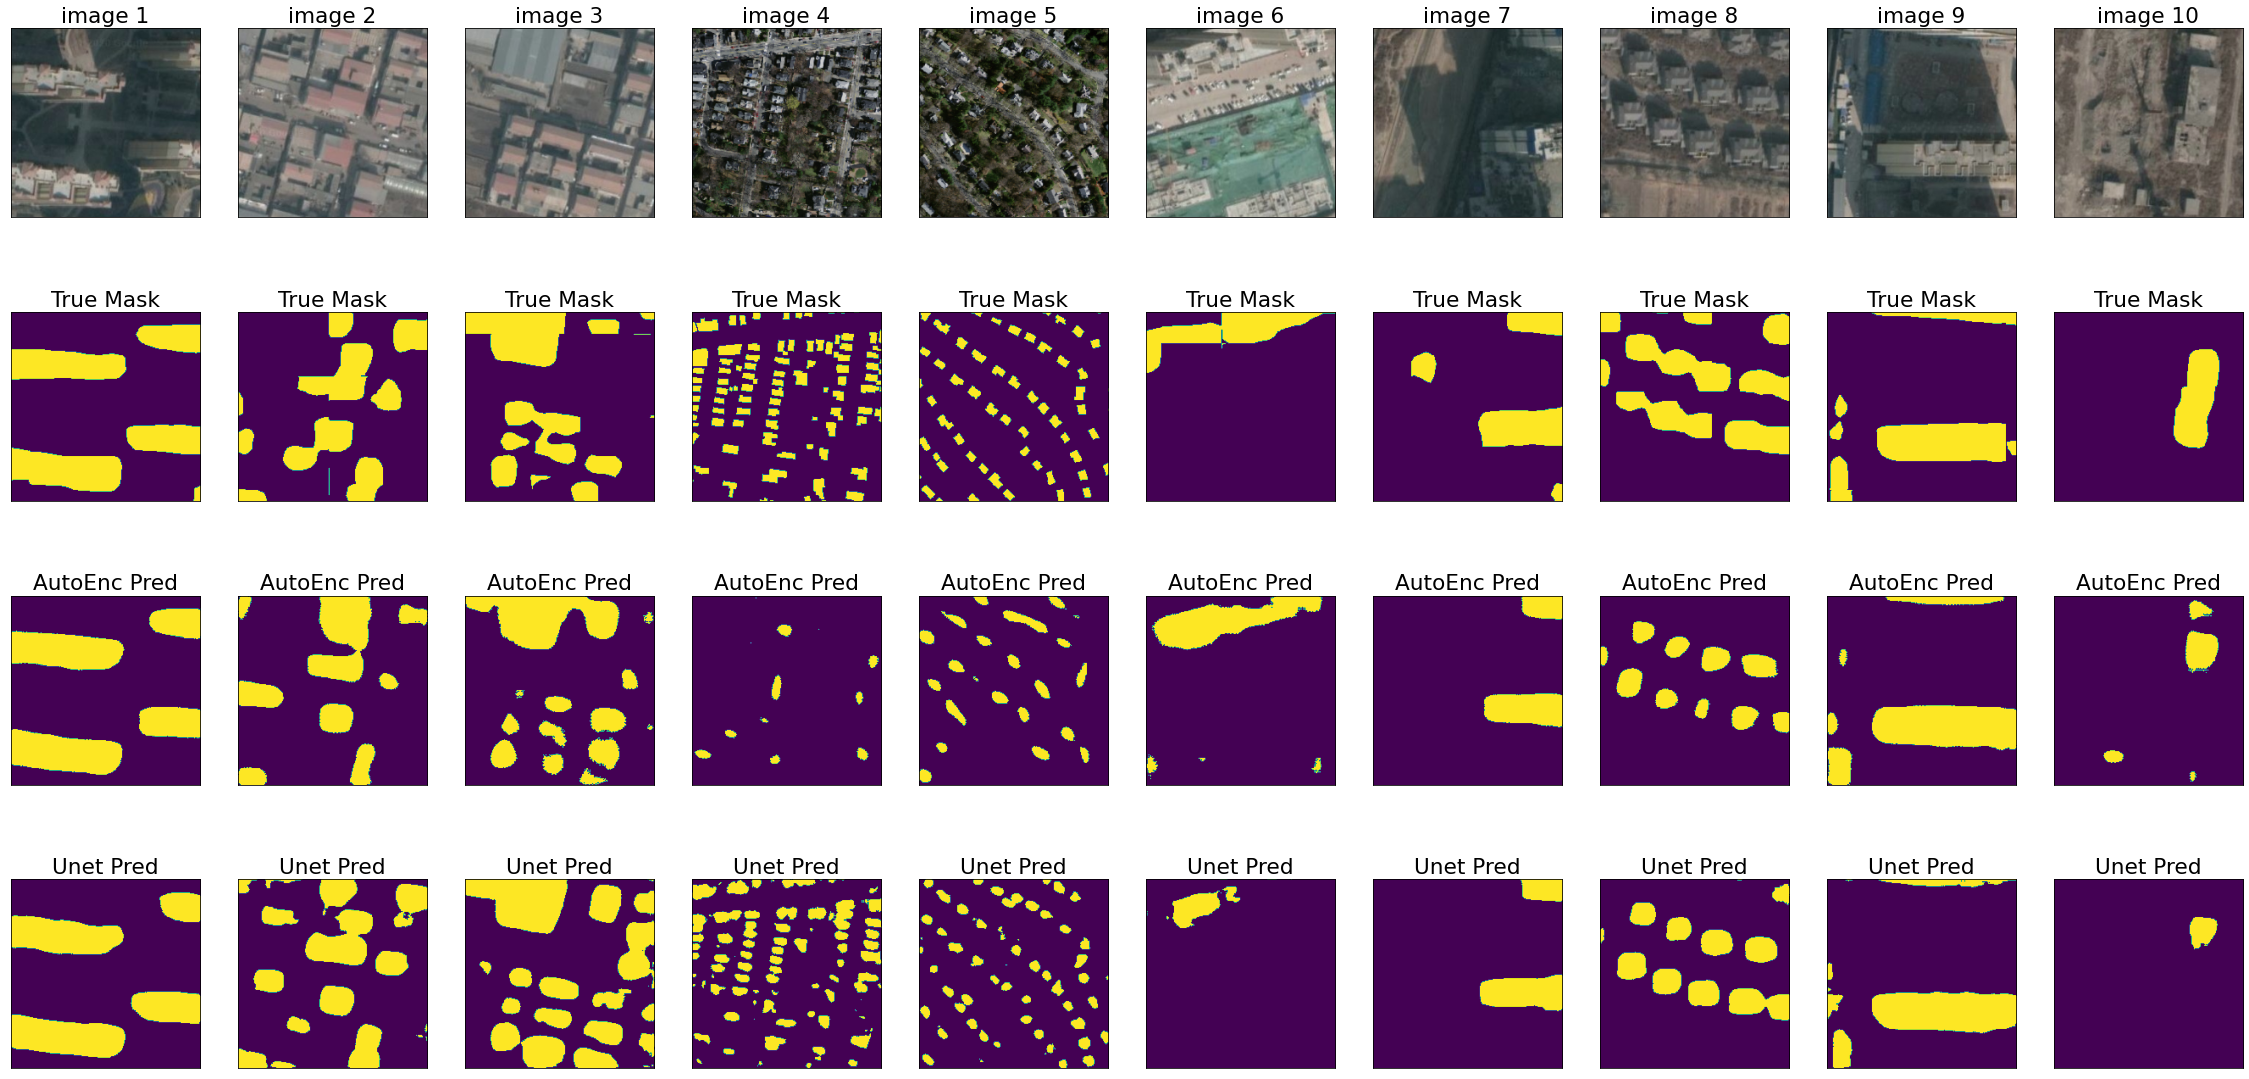

In [ ]:
# write your code below

# plot the images

for x, y in test_dataset.take(1):
    
    pred_autoEnc=model_autoEnc(x,training=False)
    pred_autoEnc=tf.argmax(pred_autoEnc,axis=-1)

    pred_unet = model_unet(x, training= False)
    pred_unet = tf.argmax(pred_unet, axis=-1)

    n = 10
    plt.figure(figsize=(40, 20))
    plt.rcParams['font.size'] = '18'


    for i in range(n):
        
        plt.subplot(4, n, i + 1)
        plt.title(f"image {i+1}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x[i])
     
        plt.subplot(4, n, n+i + 1)
        plt.title("True Mask")
        plt.xticks([])
        plt.yticks([])        
        plt.imshow(tf.argmax(y[i],axis=-1).numpy().reshape(224,224))
    
        plt.subplot(4, n, 2*n + i+1)
        plt.title("AutoEnc Pred")
        plt.xticks([])
        plt.yticks([])         
        plt.imshow(pred_autoEnc[i])

        plt.subplot(4, n, 3*n + i+1)
        plt.title("Unet Pred")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pred_unet[i])

